<a href="https://colab.research.google.com/github/enesyurt/Amazon-Sentiment-Analysis/blob/main/NLP_Amazon_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

In [ ]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# amazon.csv verisini okut.
df = pd.read_excel("amazon.xlsx")

In [ ]:
# Tüm harfleri küçük harfe çevir
df["Review"] = df["Review"].str.lower()

In [ ]:
# Noktalama işaretlerini kaldır
df["Review"] = df["Review"].str.replace("[^\w\s]", "")

In [ ]:
# Sayısal ifadeleri çıkar
df["Review"] = df["Review"].str.replace("\d", "")

In [ ]:
import nltk
nltk.download('stopwords')
# Stopwordleri çıkar
sw = stopwords.words("english")
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [ ]:
# 1000'den az geçen kelimeleri veriden çıkar
drops = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [ ]:
import nltk
nltk.download('wordnet')
# Lemmatization işlemini gerçekleştir (Kelimeleri köklerine çevir)
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review'].head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck cant believe quality material ...
5                                 look different photo
6    exactly looking heavy material great price shi...
7    looking picture thought curtain would thinner ...
8    much whiter thought would wasnt really expecti...
9    curtain picture show rd set ambesonne curtain ...
Name: Review, dtype: object

In [ ]:
# Rewiev değişkeninin içerdiği kelimelerin frekanslarını hesaplayıp tf olarak kaydet
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns=["words","tf"]
sorted_tf = tf.sort_values("tf", ascending=False)

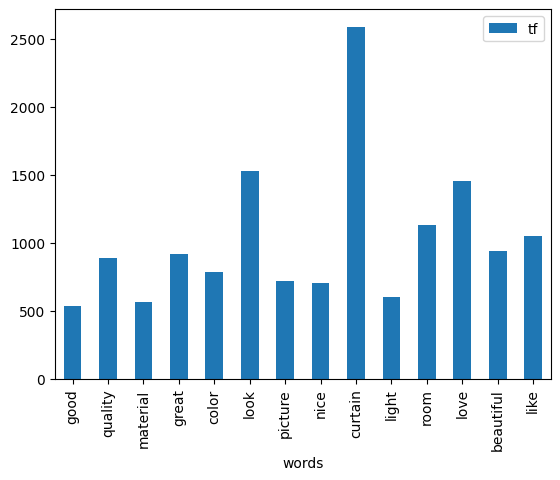

In [ ]:
# 500'den fazla geçen kelimeleri Barplotta göster
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [ ]:
# Review" değişkeninin içerdiği tüm kelimeleri string olarak kaydet
text = " ".join(i for i in df.Review)

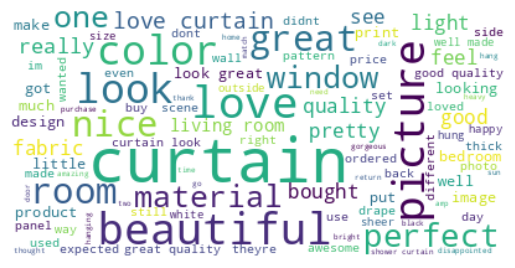

In [ ]:
# Wordcloud oluştur
wordcloud = WordCloud(max_font_size = 50,
                      max_words = 100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud,interpolation = "bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluştur.
df.head()
# nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

In [ ]:
# "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesapla
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [ ]:
# İncelenen ilk 10 gözlem için compund skorlarına göre filtrele
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [ ]:
# Compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelle.
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]>0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [ ]:
# "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e ekle.
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]>0 else "neg")

In [ ]:
df.head(10)
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.39
pos   4.59
Name: Star, dtype: float64

In [ ]:
# Bağımlı ve bağımsız değişkenleri belirleyerek datayı train test olarak ayır.
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)

In [ ]:
# Makine öğrenmesi modeline verileri verebilmek için temsil şekillerini sayısala çevir.
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [ ]:
# Lojistik regresyon modelini kurarak train dataları ile fit et.
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

In [ ]:
# Predict fonksiyonu ile test datasını tahmin ederek kaydet.
y_pred = log_model.predict(x_test_tf_idf_word)

In [ ]:
# classification_report ile tahmin sonuçlarını raporlayıp gözlemle.
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [ ]:
# cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesapla.
log_model_accuracy = cross_val_score(log_model,x_test_tf_idf_word, test_y, cv=5).mean()
log_model_accuracy

0.8546034570411795

In [ ]:
# sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere ata.
random_review = pd.Series(df["Review"].sample(1).values)

In [ ]:
# Elde edilen örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştir.
# Vektörleştirilien örneklemi fit ve transform işlemlerini yaparak kaydet.
new_review = CountVectorizer().fit(train_x).transform(random_review)

In [ ]:
# Kurulan modele örneklemi vererek tahmin sonucunu kaydet.
pred = log_model.predict(new_review)

In [ ]:
# Örneklemi ve tahmin sonucunu ekrana yazdır.
print(f'Review:  {random_review[0]} \nPrediction: {pred}')

Review:  panel match one shorter inchesi want new set return first pair refund credited new panel second message heard nothing ambesonne 
Prediction: ['neg']


In [ ]:
# RandomForestClassifier modelini kurup fit et.
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)

In [ ]:
# Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesapla.
rf_model_accuracy = cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5).mean()
rf_model_accuracy

0.8930910015251653

In [ ]:
# Lojistik regresyon modeli ile sonuçları karşılaştır.
print(f'Lojistik regresyon doğruluk oranı: {log_model_accuracy}\nRandom Forests model doğruluk oranı: {rf_model_accuracy}')

Lojistik regresyon doğruluk oranı: 0.8546034570411795
Random Forests model doğruluk oranı: 0.8930910015251653
